In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalCntrees

In [2]:
corr = 0.

# Load Model

In [3]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_initseed4_batch512"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=17-val_loss=0.000553.ckpt


# Load Model

In [4]:
# Extract parameters using regex
import re
n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))


model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


/tmp/ipykernel_3084771/443524507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [6]:
n_eval_envs = -1 #50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


# Run Model

In [7]:
def testing_accuracy(condition):
    acc = []
    baseline_acc = []
    for i_eval in range(n_eval_envs):
        env_acc = []
        baseline_env_acc = []
        traj = eval_trajs[i_eval]
        if traj['context_rewards'][:800].sum().item() == 0:
            continue
        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': 10,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        optimal_action_map, dist_from_goal = env.make_opt_action_dict()
        if condition == 'normal':
            order = np.arange(800)
        elif condition == 'random':
            order = np.arange(800)
            np.random.shuffle(order)
        elif condition == 'reward_at_end':
            unrewarded = np.argwhere(traj['context_rewards'][:800] == 0).squeeze()
            rewarded = np.argwhere(traj['context_rewards'][:800] == 1).squeeze()
            np.random.shuffle(unrewarded)
            np.random.shuffle(rewarded)
            order = np.concatenate([unrewarded, rewarded])
        elif condition == 'reward_at_start':
            unrewarded = np.argwhere(traj['context_rewards'][:800] == 0).squeeze()
            rewarded = np.argwhere(traj['context_rewards'][:800] == 1).squeeze()
            np.random.shuffle(unrewarded)
            np.random.shuffle(rewarded)
            order = np.concatenate([rewarded, unrewarded])

        batch = {
            'context_states': np.array(traj['context_states'])[order],
            'context_actions': np.array(traj['context_actions'])[order],
            'context_next_states': np.array(traj['context_next_states'])[order],
            'context_rewards': np.array(traj['context_rewards'])[order, None],
            'query_states': np.array(traj['query_state']),
            }
        batch['zeros'] = torch.zeros(10 ** 2 + 4 + 1).float()
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states'][:800]))
        seen_states = np.unique(seen_states, axis=0) 
        for k in batch.keys():
            batch[k] = convert_to_tensor([batch[k]]).to(model.device)
        for query_state in seen_states: 
            batch['query_states'] = convert_to_tensor([query_state]).to(model.device)
            with torch.no_grad():
                out = model(batch)
            pred_action = torch.argmax(out.squeeze()).item()
            optimal_action = optimal_action_map[tuple(query_state.tolist())]
            env_acc.append(pred_action == optimal_action)
            baseline_env_acc.append(optimal_action == 0)
        acc.append(env_acc)
        baseline_acc.append(baseline_env_acc)
    return acc, baseline_acc

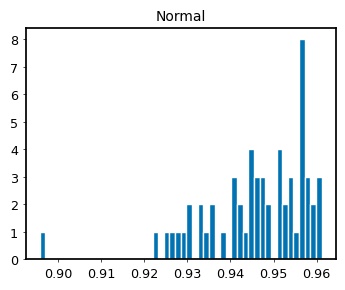

In [8]:
acc, baseline_acc = testing_accuracy('normal')
mean_acc = [np.mean(env_acc) for env_acc in acc]
mean_baseline_acc = [np.mean(env_acc) for env_acc in baseline_acc]
plt.figure(figsize=(4,3))
plt.hist(mean_acc, bins=50)
plt.title('Normal')
plt.show()


0.9176356589147286


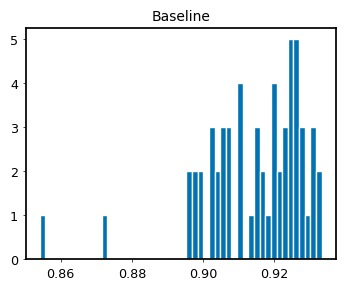

In [12]:
plt.figure(figsize=(4,3))
plt.hist(mean_baseline_acc, bins=50)
plt.title('Baseline')
print(np.median(mean_baseline_acc))
plt.show()

In [10]:
acc_many_iters = []
for _ in range(30):
    acc = testing_accuracy('reward_at_end')
    acc_many_iters.extend(acc)
mean_acc = [np.mean(env_acc) for env_acc in acc_many_iters]
plt.figure(figsize=(4,3))
plt.hist(mean_acc, bins=50)
plt.title('Reward at End')
plt.xlim(0.85, 1.0)
print(np.median(mean_acc))
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (58,) + inhomogeneous part.

In [13]:
acc_many_iters = []
for _ in range(30):
    acc = testing_accuracy('reward_at_start')
    acc_many_iters.extend(acc)
mean_acc = [np.mean(env_acc) for env_acc in acc_many_iters]
plt.figure(figsize=(4,3))
plt.hist(mean_acc, bins=50)
plt.title('Reward at Start')
plt.xlim(0.85, 1.0)
print(np.median(mean_acc))
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (58,) + inhomogeneous part.

0.9365079365079365


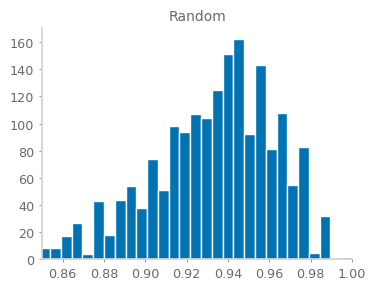

In [22]:
acc_many_iters = []
for _ in range(30):
    acc = testing_accuracy('random')
    acc_many_iters.extend(acc)
mean_acc = [np.mean(env_acc) for env_acc in acc_many_iters]
plt.figure(figsize=(4,3))
plt.hist(mean_acc, bins=50)
plt.title('Random')
plt.xlim(0.85, 1.0)
print(np.median(mean_acc))
plt.show()
